## Face and Facial Keypoint detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

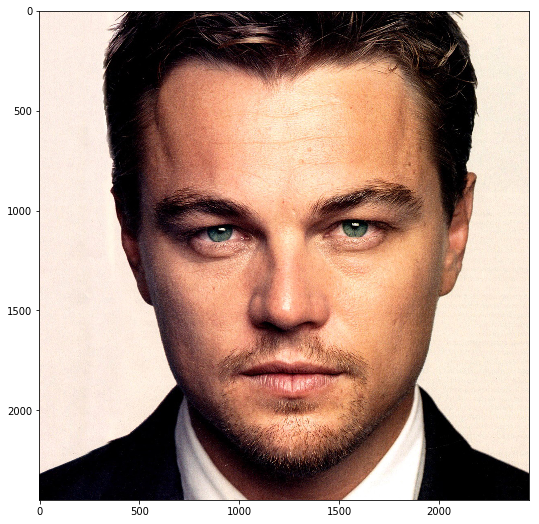

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('test.jpg')

# switch red and blue color channels 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

-  OpenCV's pre-trained Haar Cascade classifiers,

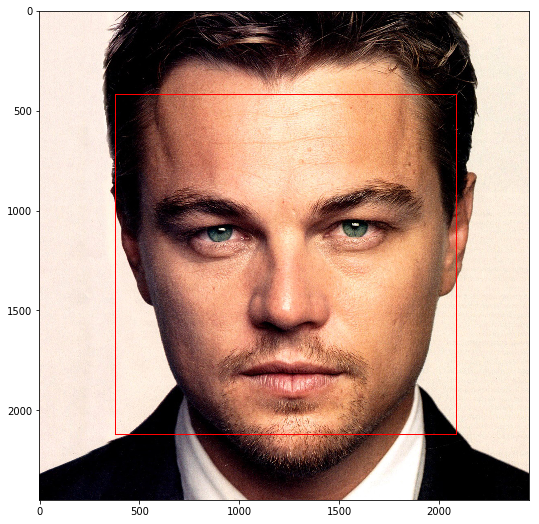

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('./detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

In [4]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=1000, out_features=800, bias=True)
  (fc2_drop): Dropout(p=0.1)
  (fc3): Linear(in_features=800, out_features=136, bias=True)
)

## Keypoint detection


###Transform each detected face into an input Tensor

1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.


### Detect and display the predicted keypoints

In [ ]:
image_copy = np.copy(image)

for i, (x,y,w,h) in enumerate(faces):
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi,(224,224))
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    torch_roi = roi.reshape(1, roi.shape[0], roi.shape[1], 1)
    torch_roi = torch_roi.transpose((0, 3, 1, 2))
    torch_roi = torch.from_numpy(torch_roi).type(torch.FloatTensor)

    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    output_pts = net(torch_roi)
    ## TODO: Display each detected face and the corresponding keypoints        

    # un-transform the predicted key_pts data
    predicted_key_pts = output_pts.data
    predicted_key_pts = predicted_key_pts.numpy()
     
    # reshape to 68 x 2 pts
    predicted_key_pts = predicted_key_pts[0].reshape((68, 2))
    
    # undo normalization of keypoints
    output_pts = predicted_key_pts*50.0+100.0
    fig.add_subplot(1, 2, i+1)
    plt.imshow(roi, cmap='gray')
    plt.scatter(output_pts[:,0], output_pts[:,1], s=20, marker='.', c='m')